We get data from Deribit for ETH spot price and options price. The available data is in different files for different strike price and expiration dates. The option type we choose is European call option.

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools
from scipy.interpolate import interp1d
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsa
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Since the data set contains separate files for different days from Sep 2022 to Oct 2022, we write function to extract necessary columns and join different days to a single dataframe.
The following function processes cleaning on spot data. We remove all rows with empty asks price or bids prices, and the rows with low trading volumn, i.e., bid and ask amount does not exceed short_exposure (usually equals to 10 ETH). 

In [2]:
def func_spot_data_cleaning(date, short_exposure):
    df = pd.read_parquet(f"~/Documents/rysk/desk/_data/store/ETH-PERPETUAL_{date}_book.parquet",\
                        columns = ['timestamp', 'asks[0].price', 'asks[1].price', 'asks[2].price', 'asks[3].price', \
                                   'asks[4].price', 'asks[0].amount', 'asks[1].amount', 'asks[2].amount', \
                                   'asks[3].amount', 'asks[4].amount', 'bids[0].price', 'bids[1].price', \
                                   'bids[2].price', 'bids[3].price', 'bids[4].price', 'bids[0].amount', \
                                   'bids[1].amount', 'bids[2].amount', 'bids[3].amount', 'bids[4].amount'])
    df = df[df['asks[0].price'].isna() == False]
    df = df[df['bids[0].price'].isna() == False]
    df = df.loc[(df['asks[0].amount'] + df['asks[0].amount'] + df['asks[0].amount'] + df['asks[0].amount']>= short_exposure) \
                & (df['bids[0].amount'] + df['bids[0].amount'] + df['bids[0].amount'] + df['bids[0].amount']>= short_exposure)]
    df = df.reset_index()
    return df

The following function compute the price from different levels of bid and ask price. If a level of price has more trading volumn, we assign a greater weight to it.

In [3]:
def func_get_price(df, short_exposure):
    df['asks_0_price'] = df['asks[0].price'] * df['asks[0].amount'].clip(upper = short_exposure)
    clip = np.array([short_exposure]*df.shape[0])
    for i in range(1,5):
        clip -= df[f'asks[{i-1}].amount']
        temp = df[f'asks_{i-1}_price']
        df[f'asks_{i}_price'] = temp + df[f'asks[{i}].price'] * df[f'asks[{i}].amount'].clip(upper = clip)
    
    df['bids_0_price'] = df['bids[0].price'] * df['bids[0].amount'].clip(upper = short_exposure)
    clip = np.array([short_exposure]*df.shape[0])
    for i in range(1,5):
        clip -= df[f'bids[{i-1}].amount']
        temp = df[f'bids_{i-1}_price']
        df[f'bids_{i}_price'] = temp + df[f'bids[{i}].price'] * df[f'bids[{i}].amount'].clip(upper = clip)
    
    df['asks_price'] = df[['asks_0_price', 'asks_1_price', 'asks_2_price', 'asks_3_price', 'asks_4_price']].max(axis=1)
    df['bids_price'] = df[['bids_0_price', 'bids_1_price', 'bids_2_price', 'bids_3_price', 'bids_4_price']].max(axis=1)
    df['price'] = (df['asks_price'] + df['bids_price'])/2/short_exposure
    return df

In [4]:
def get_ohlc_price(df, time_frame):
    df.timestamp = pd.to_datetime(df.timestamp, unit = 'us')
    df = df.set_index('timestamp')
    result = df['price'].resample(f'{time_frame}').ohlc()
    temp = df['bids[0].amount'].resample(f'{time_frame}').sum()
    result = pd.merge(result, temp, on = 'timestamp')
    return result

In [5]:
def func_agg_spot(date, short_exposure, time_frame):
    spot = func_spot_data_cleaning(date, short_exposure)
    spot = func_get_price(spot, short_exposure)
    spot = get_ohlc_price(spot, time_frame)
    return spot

We now load the spot data with 10 min interval (the original data is in microseconds) for September and October 2022.

In [6]:
#load spot data
spot = func_agg_spot('2022-09-01', 10, '10Min')
for i in range(2, 10):
    spot = pd.concat([spot, func_agg_spot(f'2022-09-0{i}', 10, '10Min')])
for i in range(10, 31):
    spot = pd.concat([spot, func_agg_spot(f'2022-09-{i}', 10, '10Min')])
for i in range(1, 10):
    spot = pd.concat([spot, func_agg_spot(f'2022-10-0{i}', 10, '10Min')])
for i in range(10, 32):
    spot = pd.concat([spot, func_agg_spot(f'2022-10-{i}', 10, '10Min')])

In [7]:
spot.head()

,open,high,low,close,bids[0].amount
timestamp,,,,,
2022-09-01 00:00:00,1552.625,1564.770,1548.625,1564.625,391381751
2022-09-01 00:10:00,1564.625,1564.775,1557.700,1557.725,338338915
2022-09-01 00:20:00,1557.725,1559.675,1552.190,1556.975,288824398
2022-09-01 00:30:00,1556.975,1560.775,1544.500,1545.425,263440716
2022-09-01 00:40:00,1545.425,1545.975,1531.750,1541.975,428533143


/var/folders/xh/6n75v1rx49x84p1xp7xtrs680000gn/T/ipykernel_48607/450035406.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(spot.index, spot.close, marker='', linestyle='-')


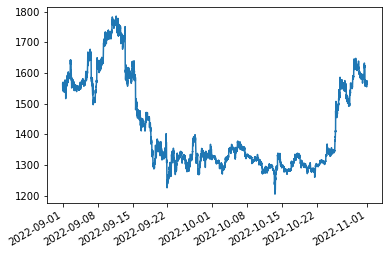

In [10]:
fig, ax = plt.subplots()
ax.plot_date(spot.index, spot.close, marker='', linestyle='-')

fig.autofmt_xdate()
plt.show()

The spot price varies between 1200 and 1800. Therefore, we consider the options with strike 1400, 1500, 1600, 1700, 1800, 1900, and 2000, with expiration date Nov 25th. The ones that is lower than 1400 and 2000 are hardly traded, so there is not enough information to predict them. We now have the function to perform data cleaning on option price data.

In [11]:
def func_option_data_cleaning(date, expiry_date, strike, option_type):
    """expiry_date '30SEP22', date '2022-09-23' """
    df = pd.read_parquet(f"~/Documents/rysk/desk/_data/store/ETH-{expiry_date}-{strike}-{option_type}_{date}_book.parquet",\
                        columns = ['timestamp', 'asks[0].price', 'asks[1].price', 'asks[2].price', 'asks[3].price', \
                                   'asks[4].price', 'asks[0].amount', 'asks[1].amount', 'asks[2].amount', \
                                   'asks[3].amount', 'asks[4].amount', 'bids[0].price', 'bids[1].price', \
                                   'bids[2].price', 'bids[3].price', 'bids[4].price', 'bids[0].amount', \
                                   'bids[1].amount', 'bids[2].amount', 'bids[3].amount', 'bids[4].amount'])
    df = df[df['asks[0].price'].isna() == False]
    df = df[df['bids[0].price'].isna() == False]
    df['difference'] = abs(df['asks[0].price'] - df['bids[0].price'])
    df = df[df['difference'] <= 0.005]
    df = df.loc[(df['asks[0].amount'] + df['asks[0].amount'] + df['asks[0].amount'] + df['asks[0].amount']>= 10) \
                & (df['bids[0].amount'] + df['bids[0].amount'] + df['bids[0].amount'] + df['bids[0].amount']>= 10)]
    df = df.reset_index()
    return df

In [12]:
def get_option_data(date, expiry_date, time_frame, short_exposure, option_type):
    levels = [1400, 1500, 1600, 1700, 1800, 1900, 2000]
    spot = func_spot_data_cleaning(date, short_exposure)
    spot = func_get_price(spot, short_exposure)
    spot = get_ohlc_price(spot, time_frame)
    spot = spot[['close']].reset_index()
    spot = spot.rename(columns = {'close':'spot'})
    
#     b = max(spot['spot'])
#     a = min(spot['spot'])
#     mask = np.array(np.array(levels) > a - 200)*np.array(np.array(levels) < b + 200)
#     strikes = np.array(levels)[mask]
#     strikes = levels
#     for i in strikes:
    for i in levels:
        option = func_option_data_cleaning(date, expiry_date ,i, option_type)
        if option.shape[0] == 0:
            continue
        option = func_get_price(option, short_exposure)
        option = get_ohlc_price(option, time_frame)
        option = option[['close', 'bids[0].amount']].reset_index()
        option = option.rename(columns = {'close':f'{i}', 'bids[0].amount':f'{i}_vol'})
        spot = pd.merge(spot, option, how = 'left', on = 'timestamp')
#     spot = spot.dropna().reset_index()
#     spot = spot.drop(columns = ['index'])
    return spot

Load option data into a dataframe called `option`.

In [ ]:
option = get_option_data('2022-09-01', '25NOV22', '10Min', 10, 'C')
for i in range(2, 10):
    option = pd.concat([option, get_option_data(f'2022-09-0{i}', '25NOV22', '10Min', 10, 'C')])
for i in range(10, 31):
    option = pd.concat([option, get_option_data(f'2022-09-{i}', '25NOV22', '10Min', 10, 'C')])
for i in range(1, 10):
    option = pd.concat([option, get_option_data(f'2022-10-0{i}', '25NOV22', '10Min', 10, 'C')])
for i in range(10, 32):
    option = pd.concat([option, get_option_data(f'2022-10-{i}', '25NOV22', '10Min', 10, 'C')])

In [16]:
#the price is in ETH, so we multiply with spot price to get price in dollars
for i in ['1400', '1500', '1600', '1700', '1800', '1900', '2000']:
    option[i] = option[i]*option['spot']

In [17]:
option.head()

,timestamp,spot,1400,1400_vol,1500,1500_vol,1600,1600_vol,1700,1700_vol,1800,1800_vol,1900,1900_vol,2000,2000_vol
0,2022-09-01 00:00:00,1564.625,NaN,NaN,318.792344,67534.0,276.156313,56480.0,238.996469,67628.0,206.530500,98030.0,178.367250,71398.0,154.115563,69488.0
1,2022-09-01 00:10:00,1557.725,NaN,NaN,314.660450,54743.0,272.601875,36322.0,235.216475,65656.0,203.283112,63065.0,175.244062,54882.0,151.488756,56038.0
2,2022-09-01 00:20:00,1556.975,NaN,NaN,314.119706,38877.0,272.081381,47025.0,235.103225,64104.0,202.795994,59136.0,174.770444,43664.0,151.026575,50837.0
3,2022-09-01 00:30:00,1545.425,NaN,NaN,307.539575,47710.0,265.813100,68580.0,229.495612,95785.0,197.814400,78468.0,170.769463,53104.0,147.201731,57835.0
4,2022-09-01 00:40:00,1541.975,NaN,NaN,304.925556,100832.0,263.292231,123147.0,227.441312,157334.0,195.445331,136925.0,168.460769,116490.0,145.716637,125224.0


We investigate the missing values.

In [18]:
option.isna().sum()

timestamp       0
spot            3
1400         2848
1400_vol     2478
1500         1107
1500_vol      653
1600          445
1600_vol      225
1700          253
1700_vol       41
1800          305
1800_vol       39
1900          470
1900_vol       35
2000          669
2000_vol       58
dtype: int64

The columns with most missing values are 1400, 1500, while 1700 has least missing columns, which is as expected. To see why this is the case, we plot the missing values of 1400, 1500, 1700 options and spot price.

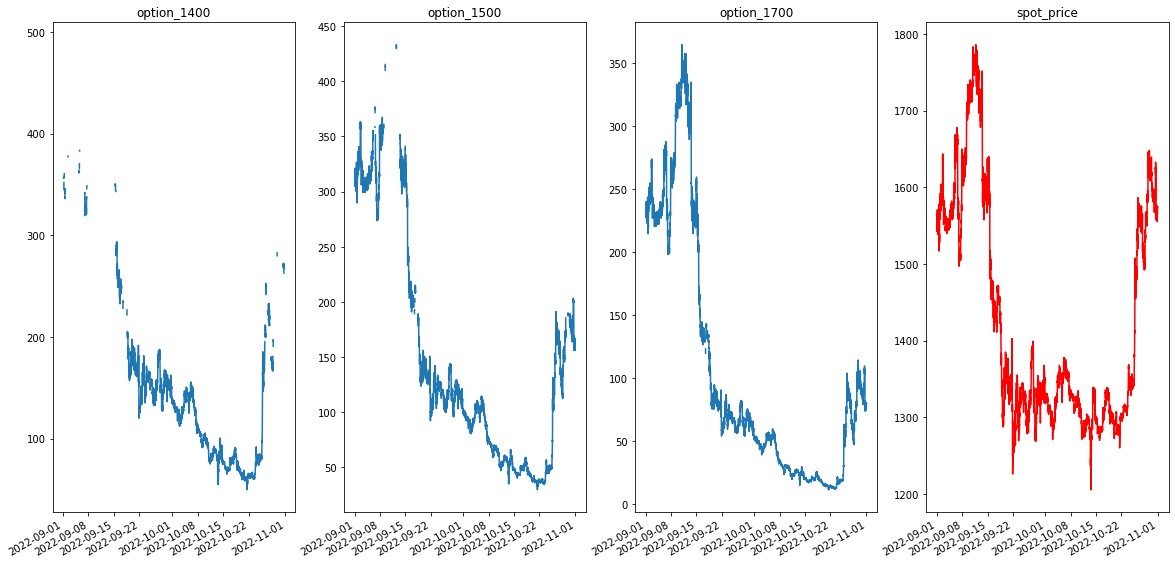

In [23]:
fig, ax = plt.subplots(1,4, figsize = (20,10))
ax[0].plot(option['timestamp'], option['1400'])
ax[1].plot(option['timestamp'], option['1500'])
ax[2].plot(option['timestamp'], option['1700'])
ax[3].plot(option['timestamp'], option['spot'], color = 'red')
ax[0].set_title('option_1400')
ax[1].set_title('option_1500')
ax[2].set_title('option_1700')
ax[3].set_title('spot_price')
fig.autofmt_xdate()

`1400_option` and `1500_option` have a lot of missing value at the beginning, which corresponds to spot price 1600~1800. This makes sense because the option is call option, so the option with strike price lower than spot price is rarely traded. On the other hand, `option_1700` is close to the spot price, so it is most traded, results in less missing values.

We perform linear interpolation to fill null values. 

In [25]:
def nan_helper(y):
    return np.isnan(y), lambda z: z.ravel().nonzero()[0]

In [26]:
for i in ['1600', '1700', '1800', '1900', '1600_vol', '1700_vol', '1800_vol', '1900_vol']:
    f = interp1d(option.index, option[i])
    price = option[i]
    nans, x= nan_helper(price)
    price[nans]= np.interp(x(nans), x(~nans), price[~nans])
    option[i] = price

/var/folders/xh/6n75v1rx49x84p1xp7xtrs680000gn/T/ipykernel_48607/3199704378.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price[nans]= np.interp(x(nans), x(~nans), price[~nans])
/var/folders/xh/6n75v1rx49x84p1xp7xtrs680000gn/T/ipykernel_48607/3199704378.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price[nans]= np.interp(x(nans), x(~nans), price[~nans])
/var/folders/xh/6n75v1rx49x84p1xp7xtrs680000gn/T/ipykernel_48607/3199704378.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

We plot out to see if the interpolation works properly.

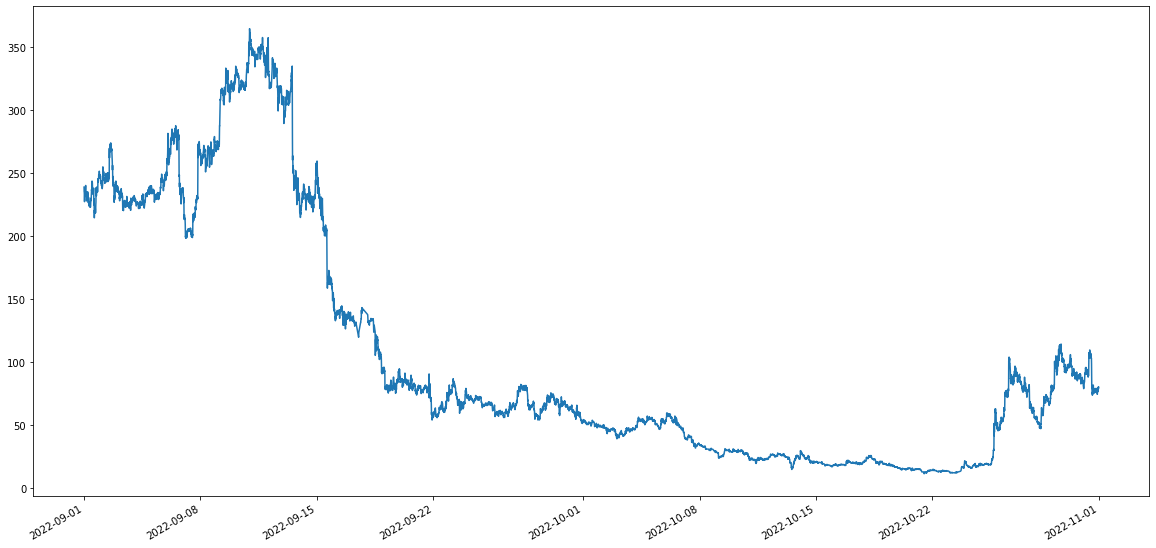

In [35]:
fig, ax = plt.subplots(1, figsize = (20,10))
ax.plot(option['timestamp'], option['1700'])
fig.autofmt_xdate()

In [210]:
#Save the file 
option.to_csv(path_or_buf = '../data/option_with_vol.csv')

We now investigate the trend and seasonality. The option we choose for our prediction model is `1700` due to availability of data.

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose 
model = seasonal_decompose(option['1700'], model = 'additive', period = 144*7)

<AxesSubplot:xlabel='timestamp'>

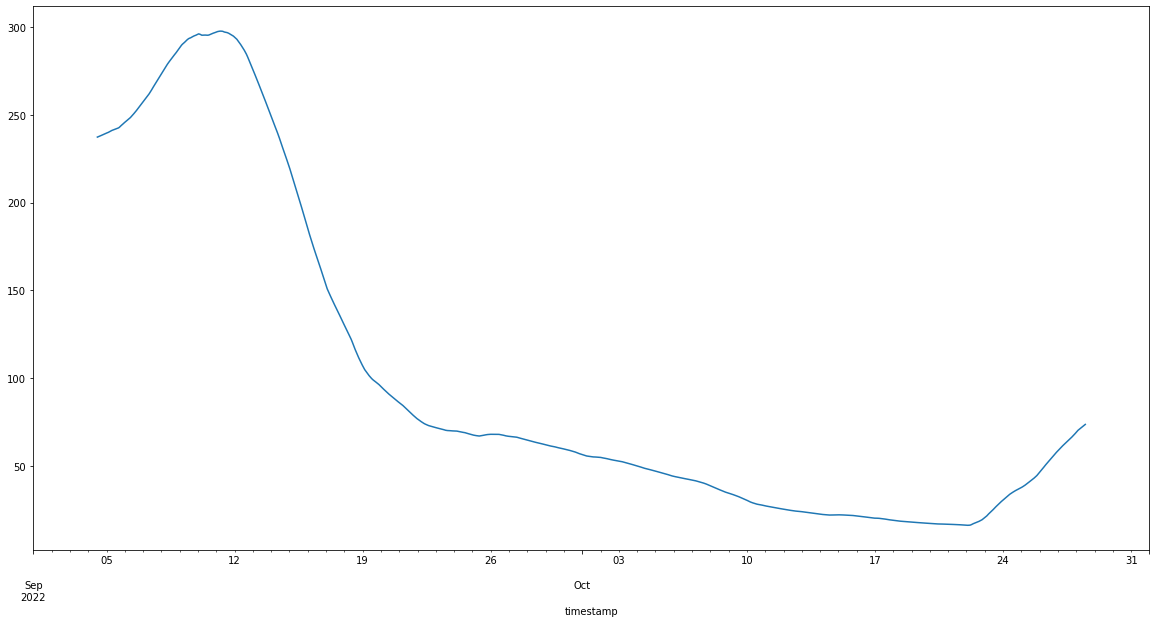

In [71]:
#trend investigation
fig, ax = plt.subplots(1, figsize = (20,10))
model.trend.plot()

<AxesSubplot:xlabel='timestamp'>

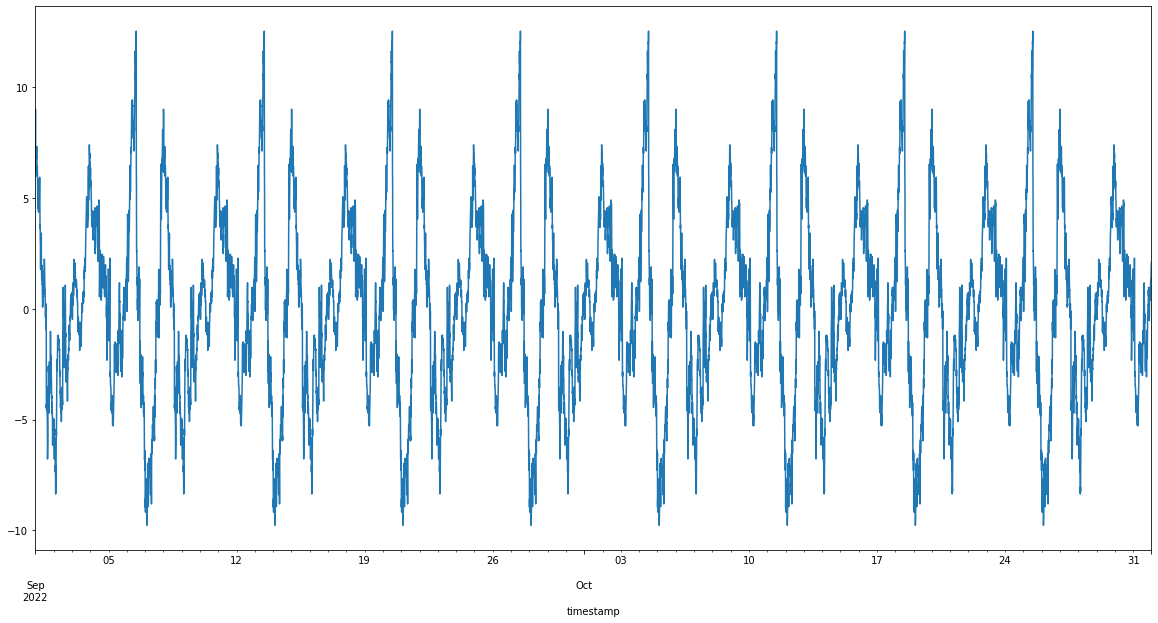

In [70]:
#seasonality investigation
fig, ax = plt.subplots(1, figsize = (20,10))
model.seasonal.plot()

The time series data shows a clear weekly seasonality. 

<AxesSubplot:xlabel='timestamp'>

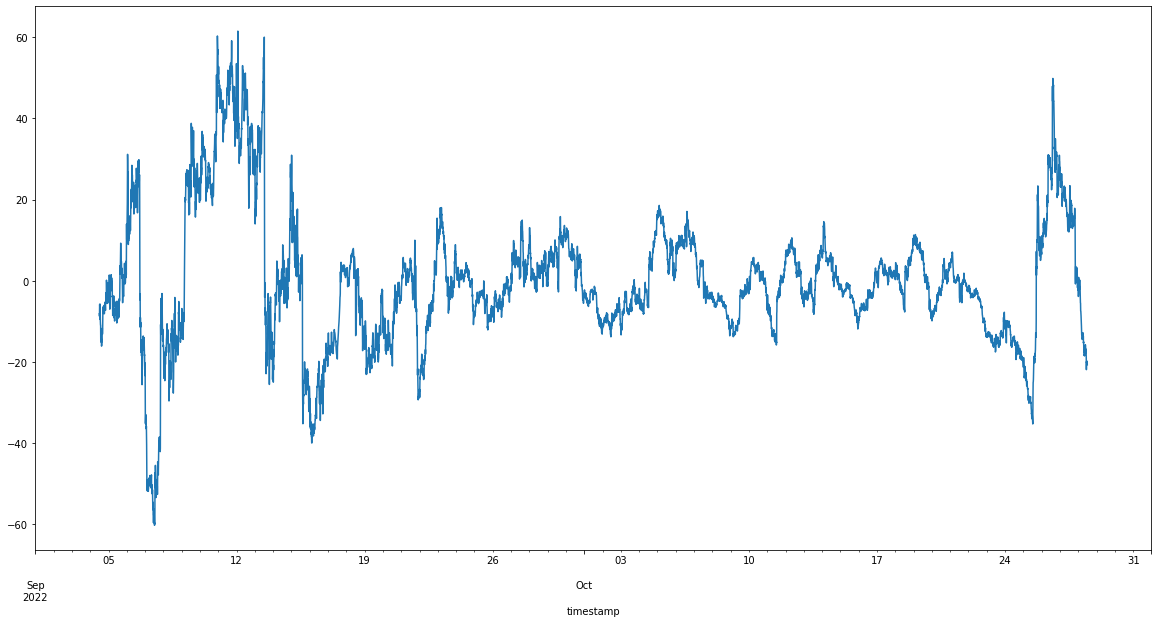

In [72]:
#residuals investigation
fig, ax = plt.subplots(1, figsize = (20,10))
model.resid.plot()

However, the residuals is quite large, with no clear pattern. 